---

# Cleanup And EDA


## Summary

In this notebook you will find process to handle missing values and perform exploratory data analysis to get better idea which feature has better correlation towards cancer classification


In [44]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import os
from pydicom import dcmread


In [45]:
# Load patients data
df = pd.read_csv("../../data/train.csv")
df.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [46]:
# Check the rows and columns
df.shape


(54706, 14)

---

## Cleaning


In [47]:
# Check null values
df.isna().sum()


site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [48]:
# Train only columns
targets = ["cancer", "biopsy", "invasive", "BIRADS", "difficult_negative_case"]
df[targets]


,cancer,biopsy,invasive,BIRADS,difficult_negative_case
0,0,0,0,NaN,False
1,0,0,0,NaN,False
2,0,0,0,NaN,False
3,0,0,0,NaN,False
4,0,0,0,0.0,True
...,...,...,...,...,...
54701,0,0,0,1.0,False
54702,0,0,0,NaN,False
54703,0,0,0,NaN,False
54704,0,0,0,0.0,True


---

- Dropping machine_id column since it has half of the records we have and it might be useful for EDA to find out about which machine getting it correct
- Dropping age column missing values since its only 37 records and using imputer may skew the analysis result


In [49]:
# Drop rows with nan on age
df = df[df["age"].notna()]

# Drop machine_id column
df.drop(columns="machine_id", inplace=True)


- BIRADS:
  - 0 if the breast required follow-up,
  - 1 if the breast was rated as negative for cancer, and
  - 2 if the breast was rated as normal. Only provided for train.


In [50]:
def populate_birads(row):
    """Produce BIRADS based on conditions

    Args:
        row (dataframe): Pandas dataframe

    Returns:
        int: Produced BIRADS
    """
    # If patient has no cancer and was not difficult negative case than return 2
    if (
        row["cancer"] == 0
        and pd.isnull(row["BIRADS"])
        and row["difficult_negative_case"] == False
    ):
        return 2
    # If patient has cancer and it was difficult negative case than return 0
    elif pd.isnull(row["BIRADS"]) and (
        row["difficult_negative_case"] or row["cancer"] == 1
    ):
        return 0
    # Else return 1
    elif pd.isnull(row["BIRADS"]):
        return 1

    # Return BIRADS original value
    return int(row["BIRADS"])


In [51]:
# Assign BIRADS
df["BIRADS"] = df.loc[:, df.columns].apply(lambda row: populate_birads(row), axis=1)


In [52]:
# Check if any nans left
df.isna().sum()


site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                            0
cancer                         0
biopsy                         0
invasive                       0
BIRADS                         0
implant                        0
density                    25236
difficult_negative_case        0
dtype: int64

- Density


In [53]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54669 entries, 0 to 54705
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54669 non-null  int64  
 1   patient_id               54669 non-null  int64  
 2   image_id                 54669 non-null  int64  
 3   laterality               54669 non-null  object 
 4   view                     54669 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54669 non-null  int64  
 7   biopsy                   54669 non-null  int64  
 8   invasive                 54669 non-null  int64  
 9   BIRADS                   54669 non-null  int64  
 10  implant                  54669 non-null  int64  
 11  density                  29433 non-null  object 
 12  difficult_negative_case  54669 non-null  bool   
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 5.5+ MB


In [54]:
# Take integer representation for density column
df["density"] = df["density"].map({"A": 0, "B": 1, "C": 2, "D": 3})

# Reset index since we dropped different rows and index will not match during imputer
df.reset_index(inplace=True, drop=True)


In [55]:
df.to_csv("../../data/density_train_df.csv", index=False)


**Info**: KNN Imputer was not as accurate on filling missing values for classification of density of the breast and CNN+MLP model was used for later modeling


In [56]:
# # Use KNN Imputer to populate density column
# imputer = KNNImputer(n_neighbors=3)
# temp_df = df.copy(deep=True)

# # Get dummies from object columns
# dummy_df = pd.get_dummies(temp_df, columns=temp_df.select_dtypes('object').columns)
# # Impute dataframe
# imputed_arr = imputer.fit_transform(dummy_df.values)


In [57]:
# dummy_df.columns


In [58]:
# # Store imputed values to density column
# col_i = dummy_df.columns.tolist().index('density')
# df['density'] = [round(row[col_i]) for row in imputed_arr]


In [59]:
# Check if any missing values left
df.isna().sum()


site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                            0
cancer                         0
biopsy                         0
invasive                       0
BIRADS                         0
implant                        0
density                    25236
difficult_negative_case        0
dtype: int64

- laterality


In [60]:
# Check if laterality has any other values other than `L` and `R`
df["laterality"].unique()


array(['L', 'R'], dtype=object)

- view


In [61]:
# Check orientation of the image. Keep only mediolateral oblique (MLO) view
# and cranial caudal (CC) view. In each mammogram examination,
# a breast is typically imaged with two different views MLO and CC
print(df["view"].value_counts(normalize=True))

df = df[(df["view"] == "MLO") | (df["view"] == "CC")]


MLO    0.510033
CC     0.489272
AT     0.000348
LM     0.000183
ML     0.000146
LMO    0.000018
Name: view, dtype: float64


In [62]:
df.shape


(54631, 13)

- Combine patient_id and laterality


In [63]:
df["custom_id"] = df["patient_id"].astype(str) + "-" + df["laterality"]


- Remove duplicates that way we will get unique patient with cancer to conduct an analysis
- Keep original dataframe to check view, density and laterality related analysis


In [64]:
no_duplicate_df = df.sort_values(by="cancer", ascending=False)
no_duplicate_df.drop_duplicates(keep="first", inplace=True)

# Convert string literal to integer
no_duplicate_df["laterality"] = no_duplicate_df["laterality"].map({"L": 0, "R": 1})
no_duplicate_df["view"] = no_duplicate_df["view"].map({"CC": 0, "MLO": 1})


- save it to csv


In [65]:
no_duplicate_df.to_csv("../../data/no_dubs_train.csv", index=False)


---

## EDA

Baseline score


In [66]:
no_duplicate_df["cancer"].value_counts(normalize=True)


0    0.97884
1    0.02116
Name: cancer, dtype: float64

In [67]:
base_path = "../../charts/"


C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3879938973.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(no_duplicate_df.drop(columns=['site_id', 'patient_id', 'image_id']).corr()[['cancer']].sort_values(by='cancer', ascending=False).round(5), vmin=-1, vmax=1, cmap='bone',annot=True)


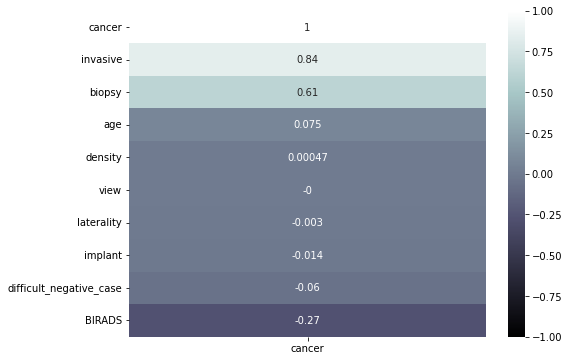

In [68]:
# Checking correlation
plt.figure(figsize=(8, 6))
sns.heatmap(
    no_duplicate_df.drop(columns=["site_id", "patient_id", "image_id"])
    .corr()[["cancer"]]
    .sort_values(by="cancer", ascending=False)
    .round(5),
    vmin=-1,
    vmax=1,
    cmap="bone",
    annot=True,
)
plt.savefig(f"{base_path}cancer_corr.png")


C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3652875772.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(no_duplicate_df.drop(columns=['site_id', 'patient_id', 'image_id','biopsy', 'invasive', 'BIRADS', 'difficult_negative_case']).corr().round(5), vmin=-1, vmax=1, cmap='bone',annot=True)


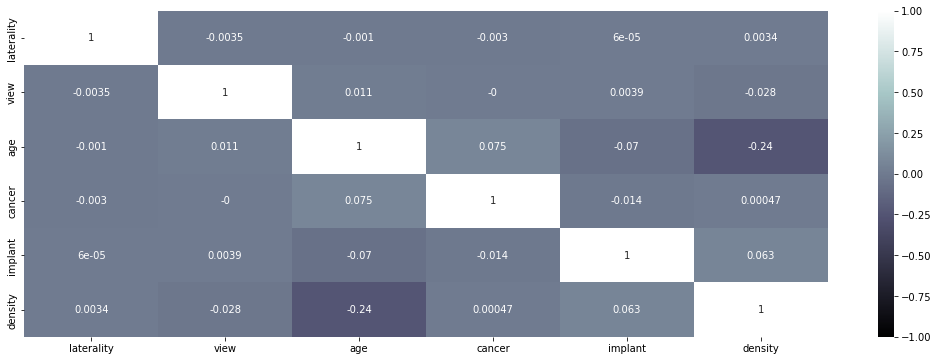

In [69]:
# Checking correlation for all
plt.figure(figsize=(18, 6))
sns.heatmap(
    no_duplicate_df.drop(
        columns=[
            "site_id",
            "patient_id",
            "image_id",
            "biopsy",
            "invasive",
            "BIRADS",
            "difficult_negative_case",
        ]
    )
    .corr()
    .round(5),
    vmin=-1,
    vmax=1,
    cmap="bone",
    annot=True,
)
plt.savefig(f"{base_path}full_corr.png")


In [70]:
def custom_plot(
    df,
    title,
    y_label,
    x_label,
    legend,
    yticklabels,
    y,
    x,
    hue,
    custom_color,
    binwidth,
    alpha,
    file_path,
):
    """Custom plot function to display histplot of given x and y values

    Args:
        df (DataFrame): Pandas dataframe
        title (string): Title of the graph
        y_label (string): y-axis label
        x_label (string): x-axis label
        legend (list): Graph list of legends
        yticklabels (list): List y-axis tick labels
        y (list): y-axis values
        x (list): x-axis values
        hue (string): Graph hue
        custom_color (Seaborn Color Palette): Seaborn color pattern
        binwidth (int): Bar bin size
        alpha (float): Bar transparency
    """
    # Set up graph layout
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot seaborn histplot
    ax = sns.histplot(
        data=df,
        y=y,
        x=x,
        hue=hue,
        palette=custom_color,
        ax=ax,
        binwidth=binwidth,
        alpha=alpha,
    )
    # Set graph title
    ax.set_title(label=title, fontsize=32)
    # Set y-axis tick labels
    ax.set_yticklabels(
        ax.get_yticklabels() if yticklabels == "self" else yticklabels, fontsize=15
    )
    # Set y-axis label
    ax.set_ylabel(y_label)
    # Set x-axis label
    ax.set_xlabel(x_label, fontsize=25)
    # Set x-axis tick labels
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
    # Set graph legend
    ax.legend(labels=legend)

    plt.savefig(f"{base_path}{file_path}")

    # Show the graph
    plt.show()


C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\2965387291.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


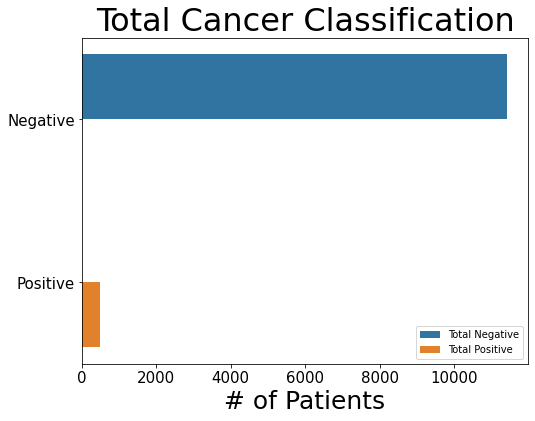

In [71]:
# Get unique patients dataframe
unique_patients_df = no_duplicate_df.drop_duplicates(subset="patient_id")

# Set up graph layout
fig, ax = plt.subplots(figsize=(8, 6))
# Plot seaborn countplot
ax = sns.countplot(data=unique_patients_df, y="cancer", hue="cancer", ax=ax)
# Set graph title
ax.set_title(label="Total Cancer Classification", fontsize=32)
# Set y-axis tick labels
ax.set_yticklabels(["Negative", "Positive"], fontsize=15)
# Set y-axis label
ax.set_ylabel(None)
# Set x-axis label
ax.set_xlabel("# of Patients", fontsize=25)
# Set x-axis tick labels
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
# Set graph legend
ax.legend(labels=["Total Negative", "Total Positive"])

plt.savefig(f"{base_path}total_classifications.png")

# Show the graph
plt.show()


- There are 11,905 patients
  - 486 Positive Cases
  - 11,419 Negative Cases


C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


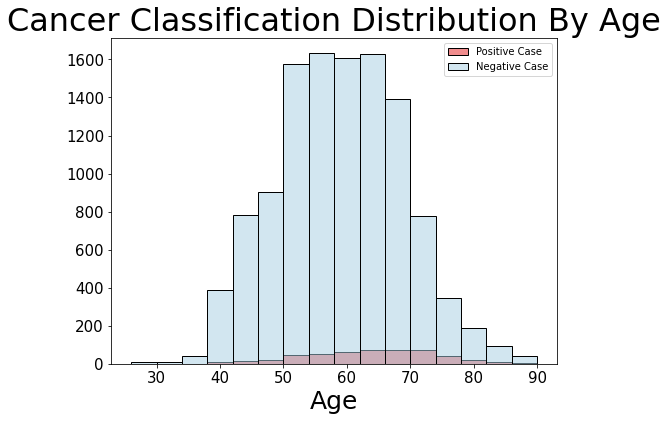

In [72]:
# Plot distribution of cancer
custom_color_palette = [sns.color_palette("Paired")[0], sns.color_palette("Paired")[5]]

# Call custom plot function
custom_plot(
    unique_patients_df,
    title="Cancer Classification Distribution By Age",
    yticklabels="self",
    y_label=None,
    x_label="Age",
    legend=["Positive Case", "Negative Case"],
    y=None,
    x="age",
    hue="cancer",
    custom_color=custom_color_palette,
    binwidth=4,
    alpha=0.5,
    file_path="age_distribution.png",
)


> Patient's age is normally distributed


In [73]:
unique_patients_df[unique_patients_df["cancer"] == 1]["age"].var()
# Variance tells you the degree of spread in your data set.
# The more spread the data, the larger the variance is in relation to the mean


97.52470408552884

C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\225257726.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data=cancer_only_df, x='age', palette=sns.color_palette('Paired')[6:9], kde=True)
C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\225257726.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=15)
C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\225257726.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


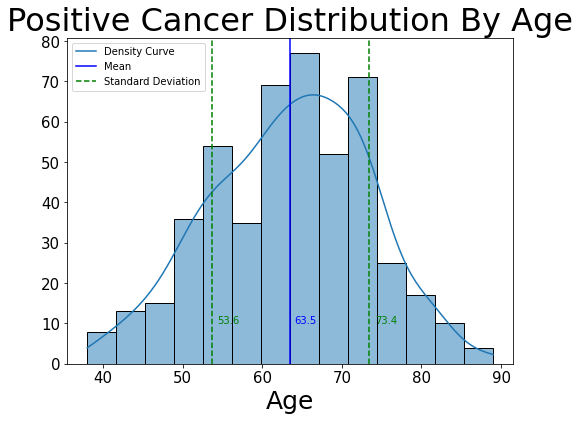

In [74]:
# Set up layout
fig, ax = plt.subplots(figsize=(8, 6))
# Prepare dataframe with cancer patients only
cancer_only_df = unique_patients_df[unique_patients_df["cancer"] == 1]
# Set up seaborn histplot
ax = sns.histplot(
    data=cancer_only_df, x="age", palette=sns.color_palette("Paired")[6:9], kde=True
)
# Set title
ax.set_title("Positive Cancer Distribution By Age", fontsize=32)
# Set y-axis label
ax.set_ylabel(None)
# Set y-axis tick labels
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=15)
# Set x-axis labels
ax.set_xlabel("Age", fontsize=25)
# Set x-axis tick labels
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
# Set x vertical line for average age
ax.axvline(cancer_only_df["age"].mean(), color="blue")
# Set text on vertical line for average age
ax.text(
    cancer_only_df["age"].mean() + 0.5,
    10,
    f"{cancer_only_df['age'].mean().round(1)}",
    color="blue",
)
# Set right side std distance from average age
ax.axvline(
    cancer_only_df["age"].mean() + cancer_only_df["age"].std(), color="green", ls="--"
)
# Display number for std distance from average age
ax.text(
    (cancer_only_df["age"].mean() + cancer_only_df["age"].std()) + 0.8,
    10,
    f"{(cancer_only_df['age'].mean() + cancer_only_df['age'].std()).round(1)}",
    color="green",
)
# Set vertical line left side of average age
ax.axvline(
    cancer_only_df["age"].mean() - cancer_only_df["age"].std(), color="green", ls="--"
)
# Display the number for left side of average age
ax.text(
    (cancer_only_df["age"].mean() - cancer_only_df["age"].std()) + 0.7,
    10,
    f"{(cancer_only_df['age'].mean() - cancer_only_df['age'].std()).round(1)}",
    color="green",
)
# Set legends
ax.legend(["Density Curve", "Mean", "Standard Deviation"])

plt.savefig(f"{base_path}positive_cancer_dist.png")

# Display the graph
plt.show()


In [75]:
cancer_only_df["age"].std()


9.875459689833626

C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:35: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.histplot(
C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


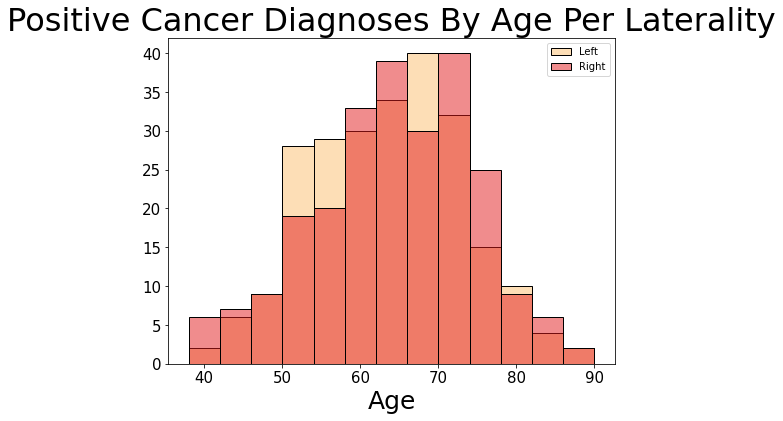

In [76]:
# Plot By Age Per Breast for positive cancer patients
custom_plot(
    cancer_only_df,
    title="Positive Cancer Diagnoses By Age Per Laterality",
    yticklabels="self",
    y_label=None,
    x_label="Age",
    legend=["Left", "Right"],
    y=None,
    x="age",
    hue="laterality",
    custom_color=sns.color_palette("Paired")[5:9],
    binwidth=4,
    alpha=0.5,
    file_path="not_used.png",
)


C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:35: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.histplot(
C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
C:\Users\btoli\AppData\Local\Temp\ipykernel_9152\3634931178.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


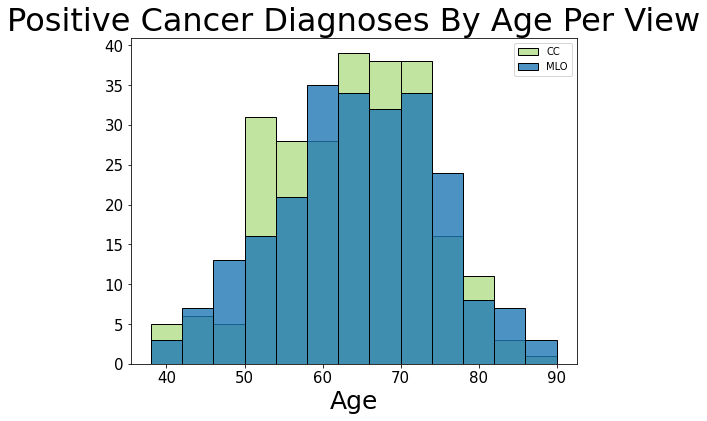

In [77]:
# Plot Age per view for positive cancer diagnoses
custom_plot(
    cancer_only_df,
    title="Positive Cancer Diagnoses By Age Per View",
    yticklabels="self",
    y_label=None,
    x_label="Age",
    legend=["CC", "MLO"],
    y=None,
    x="age",
    hue="view",
    custom_color=sns.color_palette("Paired")[1:10],
    binwidth=4,
    alpha=0.8,
    file_path="not_used.png",
)


## Mammograms

Conduct EDA on mammograms if there is anything obvious to detect with naked eye


In [82]:
def plot_mamm(item, title, file_path="none"):
    """Custom image plot for mammograms

    Args:
        item (DataFrame): Pandas dataframe
        title (string): Graph title
    """
    # Read image with given path
    ds = dcmread(f"../../data/train_images/{item['patient_id']}/{item['image_id']}.dcm")

    # Set image layout
    plt.figure(figsize=(15, 10))
    # Plot image
    plt.imshow(ds.pixel_array, cmap="bone")  # set the color map to bone
    # Set title
    plt.title(title, fontsize=15)
    # Turn off axis
    plt.axis("off")
    # plt.savefig(f'{base_path}{file_path}')
    # Display the image
    plt.show()


In [79]:
# Check cancer only dataframe
cancer_only_df.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,custom_id
18859,1,29919,1361547019,1,0,58.0,1,1,1,0,0,1.0,False,29919-R
51437,2,65492,1186509485,0,1,59.0,1,1,1,0,0,NaN,False,65492-L
4538,2,14941,303808170,1,1,68.0,1,1,1,0,0,NaN,False,14941-R
30132,1,42160,684267184,1,1,68.0,1,1,1,0,0,2.0,False,42160-R
41718,2,55095,864613243,1,0,75.0,1,1,1,0,0,NaN,False,55095-R


---

### Check image

- Laterality: Left
- View: CC
- Invasive: Non Invasive
- Density: A
- Difficult Negative Case: Not Difficult Case
- Cancer: Positive Cancer


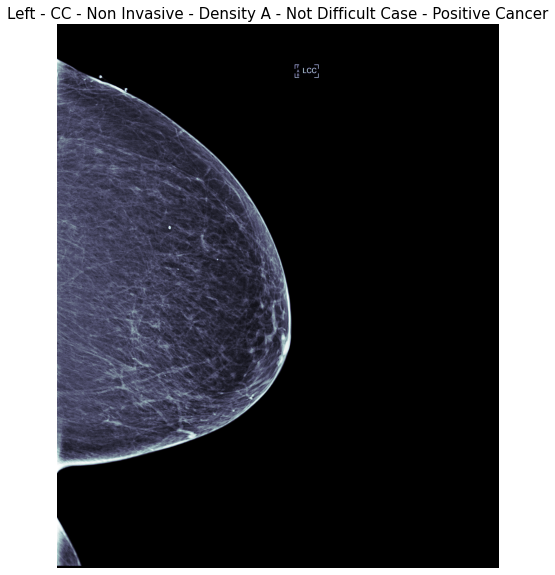

In [80]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 0)
    & (unique_patients_df["density"] == 0)
    & (unique_patients_df["difficult_negative_case"] == 0)
    & (unique_patients_df["cancer"] == 1)
]

plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[0],
    title="Left - CC - Non Invasive - Density A - Not Difficult Case - Positive Cancer",
    file_path="left_cc_cancer.png",
)


### Check image

- Laterality: Left
- View: CC
- Invasive: Non Invasive
- Density: B
- Difficult Negative Case: Not Difficult Case
- Cancer: Positive Cancer


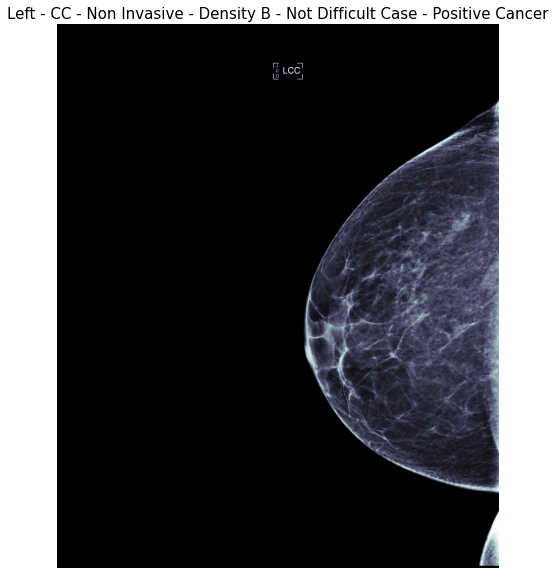

In [83]:
# Prep dataframe
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 0)
    & (unique_patients_df["density"] == 1)
    & (unique_patients_df["difficult_negative_case"] == 0)
    & (unique_patients_df["cancer"] == 1)
]

# Plot the image
plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[0],
    title="Left - CC - Non Invasive - Density B - Not Difficult Case - Positive Cancer",
)


### Check image

- Laterality: Left
- View: CC
- Invasive: Non Invasive
- Density: C
- Difficult Negative Case: Not Difficult Case
- Cancer: Positive Cancer


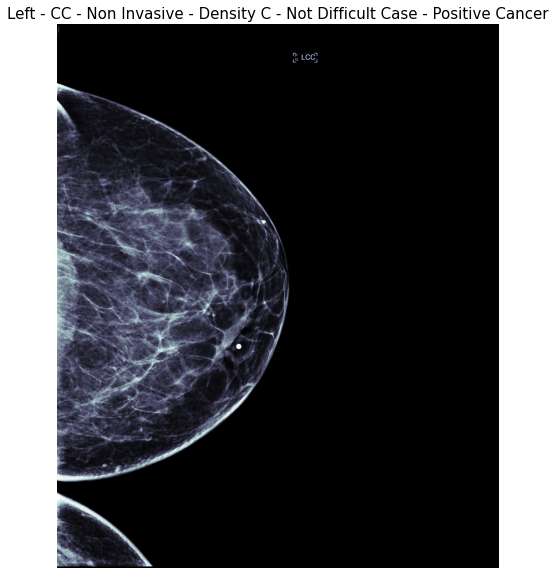

In [84]:
# Prepare dataframe
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 0)
    & (unique_patients_df["density"] == 2)
    & (unique_patients_df["difficult_negative_case"] == 0)
    & (unique_patients_df["cancer"] == 1)
]
# Plot image
plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[0],
    title="Left - CC - Non Invasive - Density C - Not Difficult Case - Positive Cancer",
    file_path="density_c_cc.png",
)


### Check image

- Laterality: Left
- View: CC
- Invasive: Non Invasive
- Density: D
- Difficult Negative Case: Not Difficult Case
- Cancer: Positive Cancer


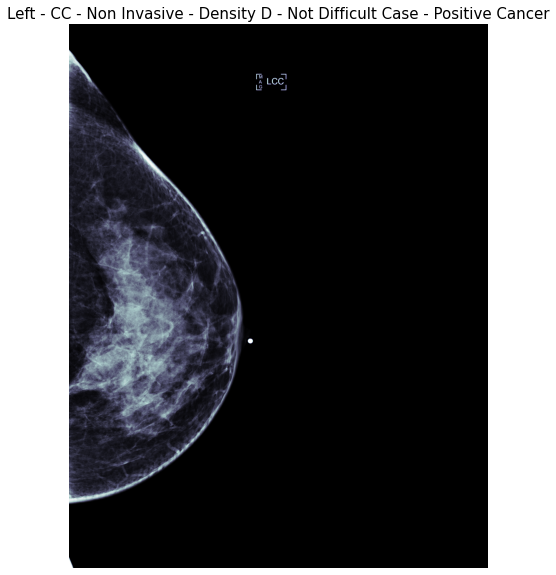

In [85]:
# Prepare dataframe
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 0)
    & (unique_patients_df["density"] == 3)
    & (unique_patients_df["difficult_negative_case"] == 0)
    & (unique_patients_df["cancer"] == 1)
]
# Plot image
plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[0],
    title="Left - CC - Non Invasive - Density D - Not Difficult Case - Positive Cancer",
)


---

### Check image

- Laterality: Left
- View: CC
- Invasive: Non Invasive
- Density: B
- Difficult Negative Case: Not Difficult Case
- Cancer: Positive Cancer


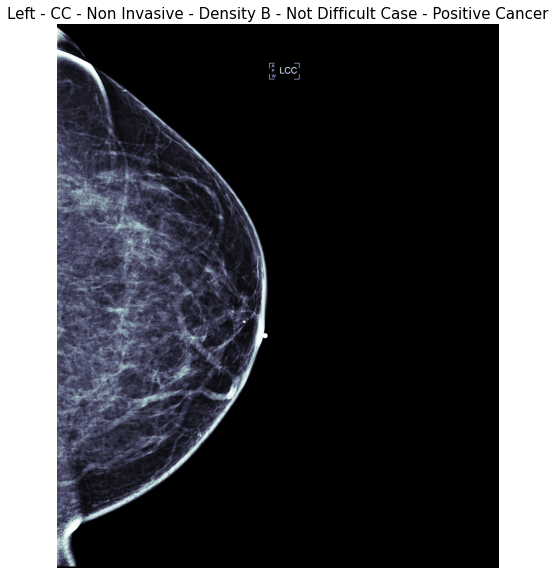

In [86]:
# Prepare Dataframe
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 0)
    & (unique_patients_df["density"] == 1)
    & (unique_patients_df["difficult_negative_case"] == 0)
    & (unique_patients_df["cancer"] == 1)
]
# Plot image
plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[2],
    title="Left - CC - Non Invasive - Density B - Not Difficult Case - Positive Cancer",
)


### Check image

- Laterality: Left
- View: MLO
- Invasive: Invasive
- Density: B
- Difficult Negative Case: Not Difficult Case
- Cancer: Positive Cancer


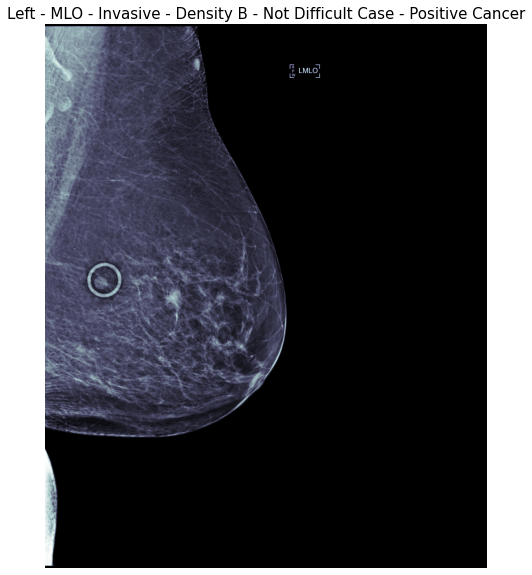

In [87]:
# Prepare dataframe
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 1)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 1)
    & (unique_patients_df["density"] == 1)
    & (unique_patients_df["difficult_negative_case"] == 0)
    & (unique_patients_df["cancer"] == 1)
]
# Plot image
plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[0],
    title="Left - MLO - Invasive - Density B - Not Difficult Case - Positive Cancer",
)


---

### Check image

- Laterality: Left
- View: CC
- Invasive: Invasive
- Density: B
- Difficult Negative Case: Difficult Case
- Cancer: Negative Cancer


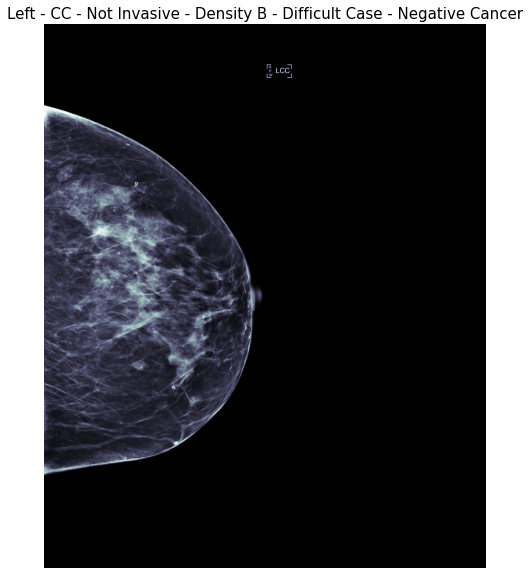

In [88]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 0)
    & (unique_patients_df["density"] == 1)
    & (unique_patients_df["difficult_negative_case"] == True)
    & (unique_patients_df["cancer"] == 0)
]
plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[0],
    title="Left - CC - Not Invasive - Density B - Difficult Case - Negative Cancer",
)


---

### Check image

- Laterality: Left
- View: MLO
- Invasive: Non Invasive
- Density: B
- Difficult Negative Case: Difficult Case
- Cancer: Positive Cancer


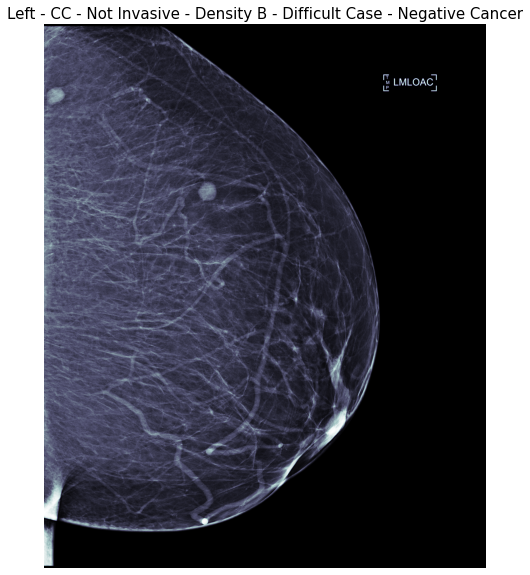

In [89]:
# Prepare dataframe
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 1)
    & (unique_patients_df["laterality"] == 0)
    & (unique_patients_df["invasive"] == 0)
    & (unique_patients_df["density"] == 1)
    & (unique_patients_df["difficult_negative_case"] == True)
    & (unique_patients_df["cancer"] == 0)
]
# Plot image
plot_mamm(
    left_cc_invasive_density_difficult_cancer.iloc[0],
    title="Left - CC - Not Invasive - Density B - Difficult Case - Negative Cancer",
)
